# Testing preprocessing techniques

In [53]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [5]:
tfds.__version__

'4.8.2'

### Useful functions

In [ ]:
# FUNCTION FOR DISPLAYING MODEL ARCHITECTURE:
# tf.keras.utils.plot_model(model, show_shapes=True)

# Count the number pixels that contain the conditional
# Unsure if this will work on multi channel images
# np.count_nonzero(created == 0)


### Display functions

In [326]:
def display(display_list):
  plt.figure(figsize=(28, 28))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# Get's the largest value between the two model filter layers then
# outputs a mask where each pixel denotes our models prediciton for each pixel
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Code from `util.py`

In [327]:
def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Resize each image from (720, 1280) -> (360, 640)
  resized = tf.image.resize(instance['image'], (360, 640))

  # Normalize the input to 0-1 range
  input_image = tf.cast(resized, tf.float32) / 255.0

  # Resize bitmask's:
  resized_bitmask = tf.image.resize(instance['label'], (360, 640))

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  bitmask_label = tf.where(resized_bitmask == 255, 1, 0) 
  
  print("preprocessing")

  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():

  train, valid = tfds.load('bdd', split=['train[:1000]', 'test[:1000]'])

  # NOTE THIS DIFFERES FROM ACTUAL PRPROCESSING IN MODEL TRAINING
  # THE DIFFERENCES BEING THIS DOESN'T use .cache() AND HAS BATCH SIZE OF 1
  train_set = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  validate_set = valid.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
# Full implementation:
   # Retrieve custom tfds of BDD10k datatset
#   dataset = tfds.load('bdd')
#   train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
#   validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)

#   test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(8)
  
  return train_set, validate_set

## Code from `model.py`

In [328]:
import tensorflow as tf
import numpy as np
# from tensorflow_examples.models.pix2pix import pix2pix

''' 
Code pulled from tensforflow_examples:
  - upsample()
  - InstanceNomalization
  
  link: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

'''
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def create_ResNetV2_model():
  base_model = tf.keras.applications.ResNet50V2(input_shape=[360, 640, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
    "conv1_conv",          # (None, 360, 640, 64)
    "conv2_block1_3_conv", # (None, 180, 320, 256)
    "conv2_block3_2_conv", # (None, 90, 160, 64)
    # "conv4_block6_1_relu", # (None, 45, 80, 256)
    # "conv5_block1_1_relu" # (None, 23, 40, 512)
  ]
  
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = False

  up_stack = [
    upsample(128, 3),  # 45x80 -> 90,160
    upsample(64, 3),  
    upsample(32, 3),  
    # upsample(32, 3),  
    # upsample(18, 3),  

  ]

  return up_stack, down_stack

def resnet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[360, 640, 3])

  up_stack, down_stack = create_ResNetV2_model()

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
  

# Model_3 Testing

- 2 output channels compiled with SparseCategoricalCrossentropy loss function
- Trained with 1000 instances, batch size == 4, no shuffling,
- Trained for 15 epochs
- Ran with bash script with 54gb allocated

In [329]:
untrained_model = resnet_model(output_channels=2)
untrained_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


trained_model = load_keras_model("model_3")

train_set, validate_set = load_10k_data()

preprocessing
preprocessing


TRAINED MODEL
1/1 [==============================] - 1s 568ms/step


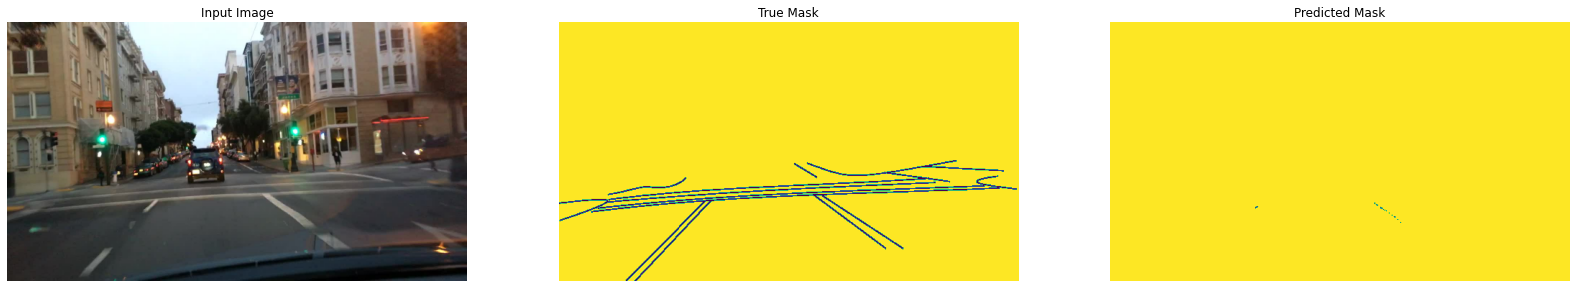

UNTRAINED MODEL
1/1 [==============================] - 0s 453ms/step


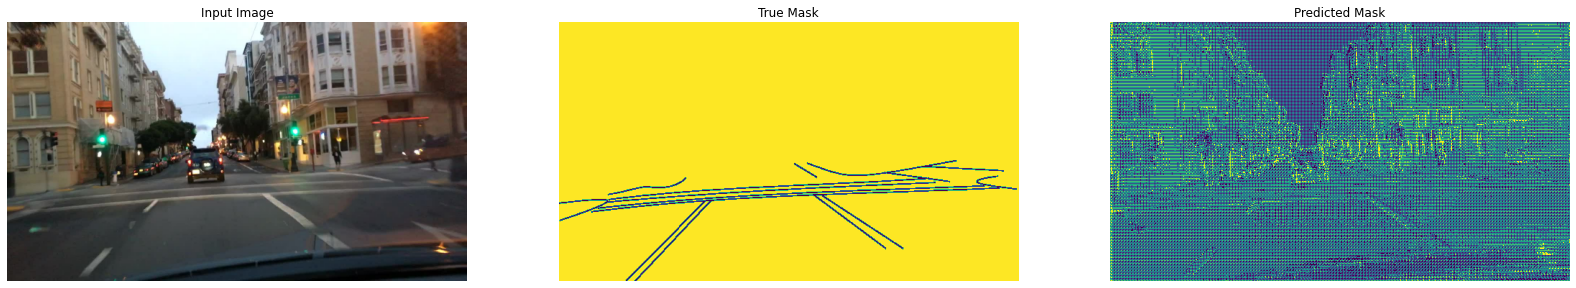

In [330]:
index = 0
for data in train_set:
  # if index < 35:
  #   index += 1
  #   continue 

  dat_img = data[0] # dat_img.shape => (1, 360, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 360, 640, 1)

  unbatched_img = dat_img[0] # shape => (360, 640, 3)
  unbatched_mask = original_mask[0] # shape => (360, 640, 1)

  # predicted_mask = model.predict(none_batched_img) # shape => (360, 640, 1)
  # created_mask = create_mask(model.predict(none_batched_img)) # shape => (360, 640, 1)

  print("TRAINED MODEL")
  display([unbatched_img, unbatched_mask, create_mask(trained_model.predict(dat_img))])

  print("UNTRAINED MODEL")
  display([unbatched_img, unbatched_mask, create_mask(untrained_model.predict(dat_img))])

  break

## Model 1 Trained with 1 outupt channel
- NOTE this section can be neglected since a valid model should have 2 output channels but is left here as a reference

In [321]:
model_1 = load_keras_model("model_1")


1/1 [==============================] - 0s 200ms/step
(1, 360, 640, 1)


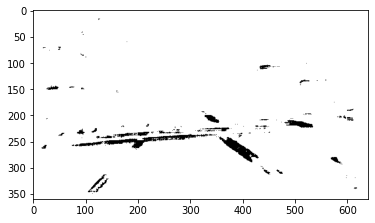

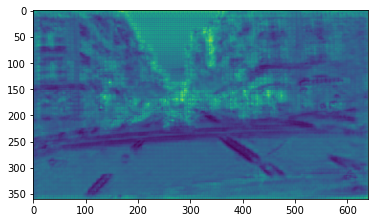

In [325]:
for data in train_set:
  dat_img = data[0]
  original_make = data[1]

  pred_mask = model_1.predict(dat_img)
  print(pred_mask.shape)
  
  # Manually using threshold to get output
  new_msk = tf.where(pred_mask >= 2.5, 255, 0)

  plt.imshow(new_msk[0], cmap="gray")
  plt.show()

  plt.imshow(pred_mask[0])
  plt.show()


  break
